In [2]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
class Loader:
    # loader is responsible for loading the audio file

    def __init__(self, sample_rate, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.mono = mono

    def load(self, file_path):
        #y: Vector 1D amptiplude across time
        #sr: sampling frequency (HZ), the number of samples of audio data captured per second
        y, sr = librosa.load(file_path)
        if sr !=  self.sample_rate:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.sample_rate)
        return y


class Padder:
    # Padder is responsible to apply padding to an array

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array


class LogSpectrogramExtractor:
    # LogSpectrogramExtractor extracts log spectrogram (in dB) from a time series signal
    # Fourier Transform

    def __init__(self, frame_size, hop_length):
        self.frame_rate = frame_size
        self.hop_length = hop_length

    def _random_10s(self, signal):
        section_start = np.random.randint(0, signal.shape[0] - 10 * 22050)
        section_end = section_start + 10 * 22050
        section = signal[section_start:section_end]
        return section

    def extract(self, spec_type, signal):
        try:
            if spec_type == "MEL":
                return self._extract_mel(signal)
            elif spec_type == "STFT":
                return self._extract_stft(signal)
            raise Exception('MEL', 'STFT')
        except Exception as inst:
            print("Only Mel-Spec and STFT-Spec is handled: ", inst.args)

    def _extract_stft(self, signal):
    
        
        # Select a random 10-second section
        signal = self._random_10s(signal)
        
        frames = librosa.util.frame(signal, frame_length=self.frame_rate, hop_length=self.hop_length)
        

        frames_normalized = librosa.util.normalize(frames)

        spec = np.abs(librosa.stft(frames_normalized)) ** 2
        log_spec = librosa.amplitude_to_db(spec, ref=np.max)

        # Resize the spectrogram to 313x149 
        spectrogram = librosa.util.fix_length(log_spec[:,:,0], size=149, axis=1)
        spectrogram = librosa.util.fix_length(spectrogram, size=313, axis=0)
        return spectrogram

    def _extract_mel(self, signal):
        signal = self._random_10s(signal)

        spectrogram = librosa.feature.melspectrogram(y=signal, sr=22050, n_fft=2048, hop_length=self.hop_length, n_mels=149)

        # convert to decibel scale
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

        # transpose to have time as the first dimension and frequency as the second dimension
        spectrogram_db = np.transpose(spectrogram_db)

        return spectrogram_db

class Saver:
    # Saver is responsible to save features, and the min max values

    def __init__(self, feature_save_dir):
        self.feature_save_dir = feature_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        with open(save_path, 'wb') as f:
            np.save(f, feature, allow_pickle=True)
        return save_path

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path


class PreprocessingPipeline:
    """
    PreprocessingPipeline processes audio files in a directory,
    applying the following to each file
        1 - load a file
        2 - pad the signal (if necessary)
        3 - extracting log spectrogram from signal
        4 - normalise spectrogram
        5 - save the normalised signal
    storing all the min max values for all the log spectrogram
    """

    def __init__(self, spec_type = "MEL"):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None
        self.spectrogram_type = spec_type

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(self.loader.sample_rate * self.loader.duration)

    def process(self, audio_files_directory):
        # print(os.walk(audio_files_directory))
        for root, _, files in os.walk(audio_files_directory):
            for file in files:
                file_path = os.path.join(root, file)
                self._process_file(file_path)
                print(f"Processed file {file_path}")

    def _process_file(self, file_path):
        signal = self.loader.load(file_path)
        feature = self.extractor.extract(self.spectrogram_type, signal)
        save_path = self.saver.save_feature(feature, file_path)

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

In [6]:
## parameter define:

FOLDER_PATH = os.getcwd()

FRAME_SIZE = 2048
HOP_LENGTH = int(22050 // 31.25)
DURATION = 15 # In seconds
SAMPLE_RATE = 22050
N_FFT = 2048
N_MELS = 128
MONO = True

SPECTROGRAM_SAVE_DIR = FOLDER_PATH+ "/spectograms"
SPECTROGRAM_313x149_SAVE_DIR = FOLDER_PATH+ "/spectograms_313x149_Mel_func"
FILES_DIR = FOLDER_PATH+"/audio"

In [7]:
if __name__ == "__main__":

    loader = Loader(SAMPLE_RATE, DURATION, MONO)
    padder = Padder()
    log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
    saver = Saver(SPECTROGRAM_313x149_SAVE_DIR)

    preprocessing_pipeline = PreprocessingPipeline()
    preprocessing_pipeline.loader = loader
    preprocessing_pipeline.padder = padder
    preprocessing_pipeline.extractor = log_spectrogram_extractor
    preprocessing_pipeline.saver = saver
    

    preprocessing_pipeline.process(FILES_DIR)

Processed file C:\Vu\Thesis\code\updated16.4/audio\1.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\10.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\100.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1000.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1001.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1002.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1003.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1004.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1005.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1006.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1007.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1008.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1009.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\101.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1010.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1011.mp3
Processed file C:\Vu\Thesis\code\updated16.4/au

Processed file C:\Vu\Thesis\code\updated16.4/audio\1124.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1125.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1126.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1127.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1128.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1129.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\113.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1130.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1131.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1132.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1133.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1134.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1135.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1136.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1137.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1138.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\1249.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\125.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1250.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1251.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1252.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1253.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1254.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1255.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1256.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1257.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1258.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1259.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\126.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1260.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1261.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1262.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\1372.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1373.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1374.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1375.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1376.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1377.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1378.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1379.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\138.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1380.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1381.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1382.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1383.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1384.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1385.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1386.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\1499.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\15.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\150.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1500.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1501.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1502.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1503.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1504.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1505.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1506.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1507.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1508.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1509.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\151.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1510.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1511.mp3
Processed file C:\Vu\Thesis\code\updated16.4

Processed file C:\Vu\Thesis\code\updated16.4/audio\1622.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1623.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1624.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1625.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1626.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1627.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1628.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1629.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\163.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1630.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1631.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1632.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1633.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1634.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1635.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1636.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\1746.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1747.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1748.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1749.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\175.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1750.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1751.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1752.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1753.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1754.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1755.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1756.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1757.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1758.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1759.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\176.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\187.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1870.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1871.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1872.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1873.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1874.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1875.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1876.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1877.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1878.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1879.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\188.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1880.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1881.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1882.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1883.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\1996.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1997.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1998.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\1999.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\20.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\200.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2000.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2001.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2002.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2003.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2004.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2005.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2006.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2007.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2008.mp3
Processed file C:\Vu\Thesis\code\updated16.4/a

Processed file C:\Vu\Thesis\code\updated16.4/audio\2120.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2121.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2122.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2123.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2124.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2125.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2126.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2127.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2128.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2129.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\213.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2130.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2131.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2132.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2133.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2134.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\2244.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2245.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2246.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2247.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2248.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2249.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\225.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2250.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2251.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2252.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2253.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2254.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2255.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2256.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2257.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2258.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\237.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2370.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2371.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2372.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2373.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2374.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2375.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2376.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2377.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2378.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2379.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\238.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2380.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2381.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2382.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2383.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\2493.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2494.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2495.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2496.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2497.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2498.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2499.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\25.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\250.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2500.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2501.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2502.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2503.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2504.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2505.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2506.mp3
Processed file C:\Vu\Thesis\code\updated16.

Processed file C:\Vu\Thesis\code\updated16.4/audio\2618.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2619.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\262.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2620.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2621.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2622.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2623.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2624.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2625.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2626.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2627.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2628.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2629.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\263.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2630.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2631.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\2743.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2744.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2745.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2746.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2747.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2748.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2749.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\275.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2750.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2751.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2752.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2753.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2754.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2755.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2756.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2757.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\2867.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2868.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2869.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\287.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2870.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2871.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2872.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2873.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2874.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2875.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2876.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2877.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2878.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2879.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\288.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2880.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\2993.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2994.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2995.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2996.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2997.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2998.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\2999.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\30.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\300.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3000.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3001.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3002.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3003.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3004.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3005.mp3
Processed file C:\Vu\Thesis\code\updated16.4/a

Processed file C:\Vu\Thesis\code\updated16.4/audio\3116.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3117.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3118.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3119.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\312.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3120.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3121.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3122.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3123.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3124.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3125.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3126.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3127.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3128.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3129.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\313.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\324.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3240.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3241.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3242.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3243.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3244.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3245.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3246.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3247.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3248.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3249.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\325.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3250.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3251.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3252.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3253.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\3366.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3367.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3368.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3369.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\337.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3370.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3371.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3372.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3373.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3374.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3375.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3376.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3377.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3378.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3379.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\338.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\3491.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3492.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3493.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3494.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3495.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3496.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3497.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3498.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3499.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\35.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\350.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3500.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3501.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3502.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3503.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3504.mp3
Processed file C:\Vu\Thesis\code\updated16.

Processed file C:\Vu\Thesis\code\updated16.4/audio\3614.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3615.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3616.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3617.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3618.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3619.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\362.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3620.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3621.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3622.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3623.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3624.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3625.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3626.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3627.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3628.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\3740.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3741.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3742.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3743.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3744.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3745.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3746.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3747.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3748.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3749.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\375.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3750.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3751.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3752.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3753.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3754.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\3866.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3867.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3868.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3869.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\387.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3870.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3871.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3872.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3873.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3874.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3875.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3876.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3877.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3878.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3879.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\388.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\3992.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3993.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3994.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3995.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3996.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3997.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3998.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\3999.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\40.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\400.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4000.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4001.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4002.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4003.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4004.mp3
Processed file C:\Vu\Thesis\code\updated16.4/a

Processed file C:\Vu\Thesis\code\updated16.4/audio\4114.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4115.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4116.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4117.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4118.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4119.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\412.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4120.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4121.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4122.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4123.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4124.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4125.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4126.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4127.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4128.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\424.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4240.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4241.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4242.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4243.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4244.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4245.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4246.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4247.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4248.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4249.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\425.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4250.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4251.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4252.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4253.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\4363.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4364.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4365.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4366.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4367.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4368.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4369.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\437.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4370.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4371.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4372.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4373.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4374.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4375.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4376.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4377.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\4487.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4488.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4489.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\449.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4490.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4491.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4492.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4493.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4494.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4495.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4496.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4497.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4498.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4499.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\45.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\450.mp3
Processed file C:\Vu\Thesis\code\updated16.4

Processed file C:\Vu\Thesis\code\updated16.4/audio\4611.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4612.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4613.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4614.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4615.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4616.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4617.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4618.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4619.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\462.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4620.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4621.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4622.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4623.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4624.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4625.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\4737.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4738.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4739.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\474.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4740.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4741.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4742.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4743.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4744.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4745.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4746.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4747.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4748.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4749.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\475.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4750.mp3
Processed file C:\Vu\Thesis\code\updated16

Processed file C:\Vu\Thesis\code\updated16.4/audio\4861.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4862.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4863.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4864.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4865.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4866.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4867.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4868.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4869.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\487.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4870.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4871.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4872.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4873.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4874.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4875.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\4985.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4986.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4987.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4988.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4989.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\499.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4990.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4991.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4992.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4993.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4994.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4995.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4996.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4997.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4998.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\4999.mp3
Processed file C:\Vu\Thesis\code\updated1

Processed file C:\Vu\Thesis\code\updated16.4/audio\61.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\610.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\611.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\612.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\613.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\614.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\615.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\616.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\617.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\618.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\619.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\62.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\620.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\621.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\622.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\623.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\624.mp3

Processed file C:\Vu\Thesis\code\updated16.4/audio\738.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\739.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\74.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\740.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\741.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\742.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\743.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\744.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\745.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\746.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\747.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\748.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\749.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\75.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\750.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\751.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\752.mp3

Processed file C:\Vu\Thesis\code\updated16.4/audio\867.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\868.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\869.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\87.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\870.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\871.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\872.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\873.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\874.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\875.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\876.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\877.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\878.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\879.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\88.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\880.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\881.mp3

Processed file C:\Vu\Thesis\code\updated16.4/audio\996.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\997.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\998.mp3
Processed file C:\Vu\Thesis\code\updated16.4/audio\999.mp3


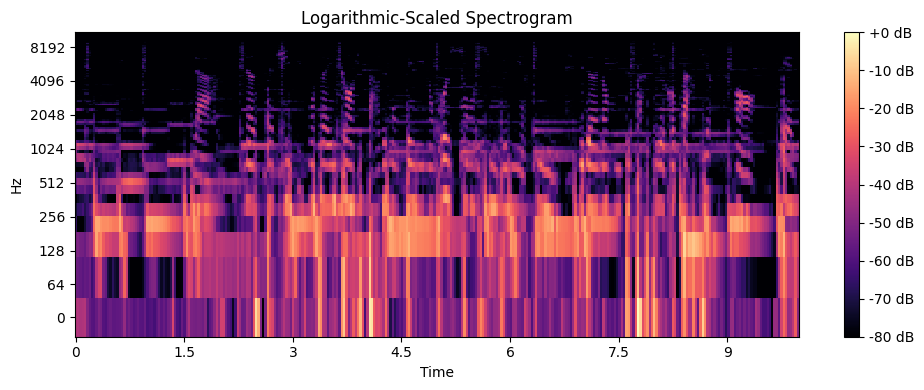

In [8]:
spec_npy = np.load(SPECTROGRAM_313x149_SAVE_DIR+'/1024.mp3.npy')
#Load Logarithmic-Scaled Spectrogram'
plt.figure(figsize=(10, 4))
librosa.display.specshow(spec_npy.T, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Logarithmic-Scaled Spectrogram')
plt.tight_layout()
plt.show()

In [9]:
spec_npy.shape

(313, 149)